In [1]:
pip install pandas scikit-learn flask gunicorn nltk


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [7]:
data = pd.read_csv('movie.csv.csv', encoding='latin1')


In [9]:
data = data[['Name', 'Genre']].dropna()


In [11]:
data['Genre'] = data['Genre'].apply(lambda x: [genre.strip() for genre in x.split(',')])


In [25]:
# Count the frequency of each genre
genre_counts = pd.DataFrame({'Genre': data['Genre'].explode().value_counts()})
rare_genres = genre_counts[genre_counts['Genre'] < 2].index.tolist()

# Print rare genres
print(f"Rare genres with fewer than 2 samples: {rare_genres}")


Rare genres with fewer than 2 samples: []


In [27]:
# Remove rows where any genre is in the rare_genres list
data = data[data['Genre'].apply(lambda genres: not any(g in rare_genres for g in genres))]


In [29]:
# Replace rare genres with "Other"
def replace_rare_genres(genres):
    return ['Other' if genre in rare_genres else genre for genre in genres]

data['Genre'] = data['Genre'].apply(replace_rare_genres)


In [31]:
genre_counts = pd.DataFrame({'Genre': data['Genre'].explode().value_counts()})
print("Updated genre counts:\n", genre_counts)


Updated genre counts:
              Genre
Genre             
Drama         7243
Action        3543
Romance       2449
Comedy        2029
Thriller      1713
Crime         1322
Family         943
Musical        589
Adventure      541
Horror         524
Mystery        513
Fantasy        458
Documentary    382
Biography      208
History        207
Animation      125
Music           90
Sport           70
Sci-Fi          58
War             47
News             9
Western          5
Reality-TV       3


In [45]:
# Flatten the genre lists and count occurrences
from collections import Counter

genre_counts = Counter([genre for genres in data['Genre'] for genre in genres])
print("Genre counts:", genre_counts)

# Identify genres with fewer than 2 samples
rare_genres = [genre for genre, count in genre_counts.items() if count < 2]
print("Rare genres (fewer than 2 samples):", rare_genres)


Genre counts: Counter({'Drama': 7243, 'Action': 3543, 'Romance': 2449, 'Comedy': 2029, 'Thriller': 1713, 'Crime': 1322, 'Family': 943, 'Musical': 589, 'Adventure': 541, 'Horror': 524, 'Mystery': 513, 'Fantasy': 458, 'Documentary': 382, 'Biography': 208, 'History': 207, 'Animation': 125, 'Music': 90, 'Sport': 70, 'Sci-Fi': 58, 'War': 47, 'News': 9, 'Western': 5, 'Reality-TV': 3})
Rare genres (fewer than 2 samples): []


In [47]:
def filter_rare_genres(genres, rare_genres):
    return [genre for genre in genres if genre not in rare_genres]

# Remove rows where all genres are rare
data['Genre'] = data['Genre'].apply(lambda genres: filter_rare_genres(genres, rare_genres))
data = data[data['Genre'].apply(len) > 0]  # Keep rows with at least one genre


In [49]:
def replace_rare_genres(genres, rare_genres):
    return [genre if genre not in rare_genres else 'Other' for genre in genres]

data['Genre'] = data['Genre'].apply(lambda genres: replace_rare_genres(genres, rare_genres))


In [51]:
# Flatten the genre lists and count occurrences again
genre_counts = Counter([genre for genres in data['Genre'] for genre in genres])
print("Updated genre counts:", genre_counts)


Updated genre counts: Counter({'Drama': 7243, 'Action': 3543, 'Romance': 2449, 'Comedy': 2029, 'Thriller': 1713, 'Crime': 1322, 'Family': 943, 'Musical': 589, 'Adventure': 541, 'Horror': 524, 'Mystery': 513, 'Fantasy': 458, 'Documentary': 382, 'Biography': 208, 'History': 207, 'Animation': 125, 'Music': 90, 'Sport': 70, 'Sci-Fi': 58, 'War': 47, 'News': 9, 'Western': 5, 'Reality-TV': 3})


In [55]:
import numpy as np

# Count occurrences of each class in the transformed target `y`
class_counts = np.sum(y, axis=0)  # Sum along columns for MultiLabelBinarizer output
print("Class counts:", class_counts)

# Identify classes with fewer than 2 samples
rare_classes = np.where(class_counts < 2)[0]  # Indices of rare classes
print("Rare classes (fewer than 2 samples):", rare_classes)


Class counts: [3543  541  125  208 2029 1322  382 7243  943  458  207  524   90  589
  513    9    3 2449   58   70 1713   47    5]
Rare classes (fewer than 2 samples): []


In [57]:
# Create a mask to keep only rows without rare classes
mask = np.all(y[:, rare_classes] == 0, axis=1)  # Check if rare classes are not present in each row
X = X[mask]
y = y[mask]


In [59]:
# Combine rare classes into a single column labeled 'Other'
y[:, rare_classes] = 0  # Remove rare class labels
other_class = np.sum(y, axis=1) == 0  # Identify rows with no labels left
y = np.hstack([y, other_class[:, None]])  # Add 'Other' class as a new column


In [61]:
# Check class distribution again
class_counts = np.sum(y, axis=0)
print("Updated class counts:", class_counts)


Updated class counts: [3543  541  125  208 2029 1322  382 7243  943  458  207  524   90  589
  513    9    3 2449   58   70 1713   47    5    0]


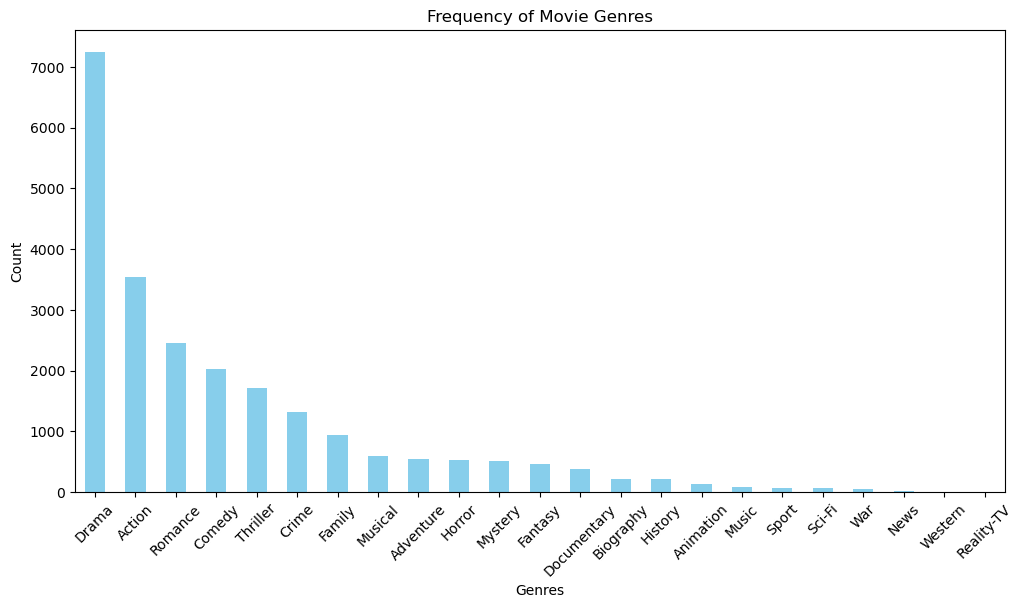

In [65]:
import matplotlib.pyplot as plt

genre_counts = data['Genre'].explode().value_counts()
genre_counts.plot(kind='bar', figsize=(12, 6), color='skyblue')
plt.title('Frequency of Movie Genres')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [69]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


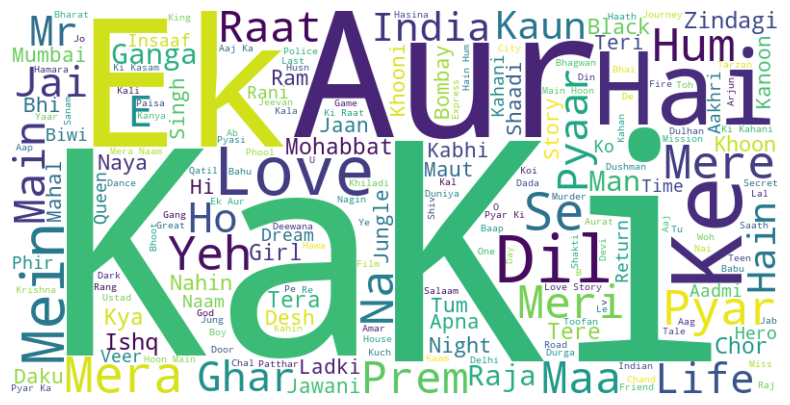

In [71]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all names into a single string, dropping NaN values
text = " ".join(data['Name'].dropna())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [75]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Example data
corpus = data['Name'].dropna()  # Ensure there are no NaN values

# Create the vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the corpus
X_train_tfidf = tfidf_vectorizer.fit_transform(corpus)

# Get feature names and scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = X_train_tfidf.sum(axis=0).A1

# Create a DataFrame of words and their TF-IDF scores
tfidf_df = pd.DataFrame({'word': feature_names, 'score': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='score', ascending=False)

print(tfidf_df.head())


     word       score
9243  the  211.681476
5011   ki  178.157150
4499   ka  143.166108
2924   ek  112.596646
838   aur  106.736763
